In [13]:
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.providers.fake_provider import FakeMelbourneV2, FakeCasablancaV2, FakeVigoV2, FakeLagosV2, FakeGuadalupeV2, FakeGuadalupe, FakeGeneva
from matplotlib import pyplot as plt
import os
import sys
import numpy as np
import argparse
import json

backend = FakeVigoV2() #5 qubits
#backend = FakeCasablancaV2() #7 qubits
#backend = FakeLagosV2() #7 qubits
#backend = FakeMelbourneV2() #14 qubits
#backend = FakeGuadalupeV2() #16 qubits
#backend = FakeGeneva() #27 qubits

shots=1024
qubits=[0,1,2,3]
num_qubits = 4

def trotterLayer(h,J,dt,n):
    trotterLayer = QuantumCircuit(num_qubits)
    trotterLayer.rx(dt*4*h, qubits)
    trotterLayer.cx(*zip(*[(qubits[2*i], qubits[2*i+1]) for i in range(n)]))
    trotterLayer.rz(-4*J*dt, [qubits[2*i+1] for i in range(n)])
    trotterLayer.cx(*zip(*[(qubits[2*i], qubits[2*i+1]) for i in range(n)]))
    trotterLayer.cx(*zip(*[(qubits[2*i+1], qubits[2*i+2]) for i in range(n-1)]))
    trotterLayer.rz(-4*J*dt, [qubits[2*i+2] for i in range(n-1)])
    trotterLayer.cx(*zip(*[(qubits[2*i+1], qubits[2*i+2]) for i in range(n-1)]))
    return trotterLayer

h = 1
J = -.15
dt = .2
n = 2

def maketrotterCircuit(s):
    tL = trotterLayer(h, J, dt, n)
    trotterCircuit = QuantumCircuit(num_qubits)
    for i in range(s):
        trotterCircuit = trotterCircuit.compose(tL)
        trotterCircuit.barrier()

    trotterCircuit = transpile(trotterCircuit, backend)
    return trotterCircuit

circuits = [maketrotterCircuit(i) for i in range(1,15)]

used_qubits = set()
for circuit in circuits: 
    for c in circuit: #look at the commands
        for bit in c.qubits: #record which qubits they use
            used_qubits.add(bit.index) #and save those
qubits = used_qubits
#circuits[0].draw()

C:\Users\fabri\AppData\Local\Temp\ipykernel_8084\2191748172.py:54: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  used_qubits.add(bit.index) #and save those


In [14]:
(-1)**4

1

In [22]:
res = []
for circ in circuits:
    qc = circ.copy()
    qc.measure_all()
    count= Aer.get_backend('qasm_simulator').run(qc, shots=shots).result().get_counts()
    count = {tuple(int(k) for k in key):count[key] for key in count.keys()}
    tot = 0
    for key in count.keys():
        num = sum([(-1)**bit for i, bit in enumerate(key) if len(key)-1-i in qubits])
        tot += num*count[key]
    res.append(tot/(shots*n*2))
print(res)

[0.71728515625, -0.01953125, -0.70849609375, -0.958984375, -0.634765625, 0.052734375, 0.666015625, 0.83154296875, 0.52880859375, -0.04345703125, -0.55419921875, -0.6787109375, -0.408203125, 0.08935546875]


In [24]:
noisyresult = []
for circ in circuits:
    qc = circ.copy()
    qc.measure_all()
    count= backend.run(qc, shots=shots).result().get_counts()
    count = {tuple(int(k) for k in key):count[key] for key in count.keys()}
    tot = 0
    for key in count.keys():
        num = sum([(-1)**bit for i, bit in enumerate(key) if len(key)-1-i in qubits])
        tot += num*count[key]
    noisyresult.append(tot/(shots*n*2))
print(noisyresult)

[0.67919921875, 0.00341796875, -0.59814453125, -0.79541015625, -0.5078125, 0.0361328125, 0.53369140625, 0.66748046875, 0.42626953125, -0.0341796875, -0.3759765625, -0.451171875, -0.24658203125, 0.0595703125]


Text(0, 0.5, 'Z Magnetization')

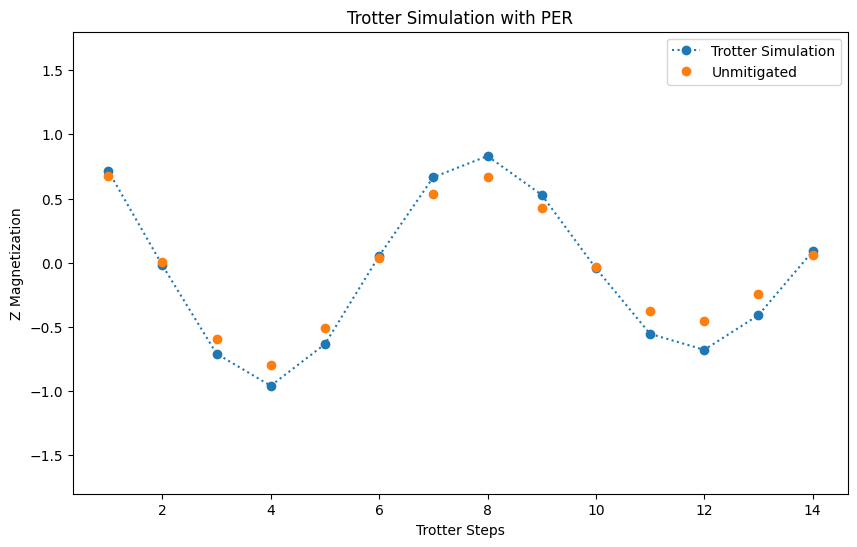

In [26]:
plt.figure(figsize=(10,6))
#for i, noise in enumerate(noise_strengths):
#    plt.plot(range(1,15), [res[i] for res in results_at_noise], 'x', label='N='+str(noise))
    
plt.plot(range(1,15), res, 'o:', label="Trotter Simulation")
plt.plot(range(1,15), noisyresult, 'o', label="Unmitigated")
#plt.errorbar(range(1,15), results, yerr=[[np.abs(res[1]) for res in results_errors],[np.abs(res[0]) for res in results_errors]],fmt='x', capsize=5, label="PER")

plt.ylim([-1.8,1.8])
plt.legend()
plt.title("Trotter Simulation with PER")
plt.xlabel("Trotter Steps")
plt.ylabel("Z Magnetization")